<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-данных" data-toc-modified-id="Импорт-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки-на-обучающую-и-тестовую" data-toc-modified-id="Разделение-выборки-на-обучающую-и-тестовую-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение выборки на обучающую и тестовую</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Таблица-результатов" data-toc-modified-id="Таблица-результатов-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Таблица результатов</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

### Импорт данных

Импортируя сделаем столбец с датой - индексами и сделаем ресемплирование по одному часу

In [36]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [37]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [38]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

Посмотрим на данные

In [39]:
display(df.shape)
display(df.info())
display(df.head())
display(df.describe())

(4416, 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Ничего удивидительного здесь нет, данных мало, всего 184 значения.

In [40]:
df.value_counts()

num_orders
73            65
57            58
66            58
78            54
84            52
              ..
232            1
238            1
239            1
240            1
462            1
Length: 251, dtype: int64

173 уникальных значения

In [41]:
df.isnull().sum()

num_orders    0
dtype: int64

нулевых значений нет  

In [42]:
df.index.is_monotonic
#проверим, что значения индекса расположены в хронологическом порядке

True

## Анализ

<AxesSubplot:xlabel='datetime'>

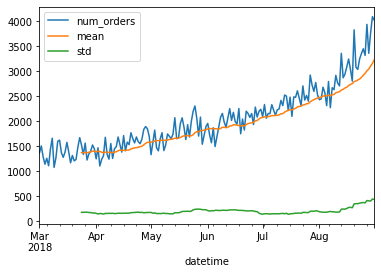

In [43]:
df_analysis = df.resample('1D').sum()
df_analysis['mean'] = df_analysis['num_orders'].rolling(24).mean()
df_analysis['std'] = df_analysis['num_orders'].rolling(24).std()
df_analysis.plot()

На первый вгляд мы видим растущий тренд от месяца к месяцу, далее посмотрим поподробнее.

***

Посмотрим на тренд и сезонность данных

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

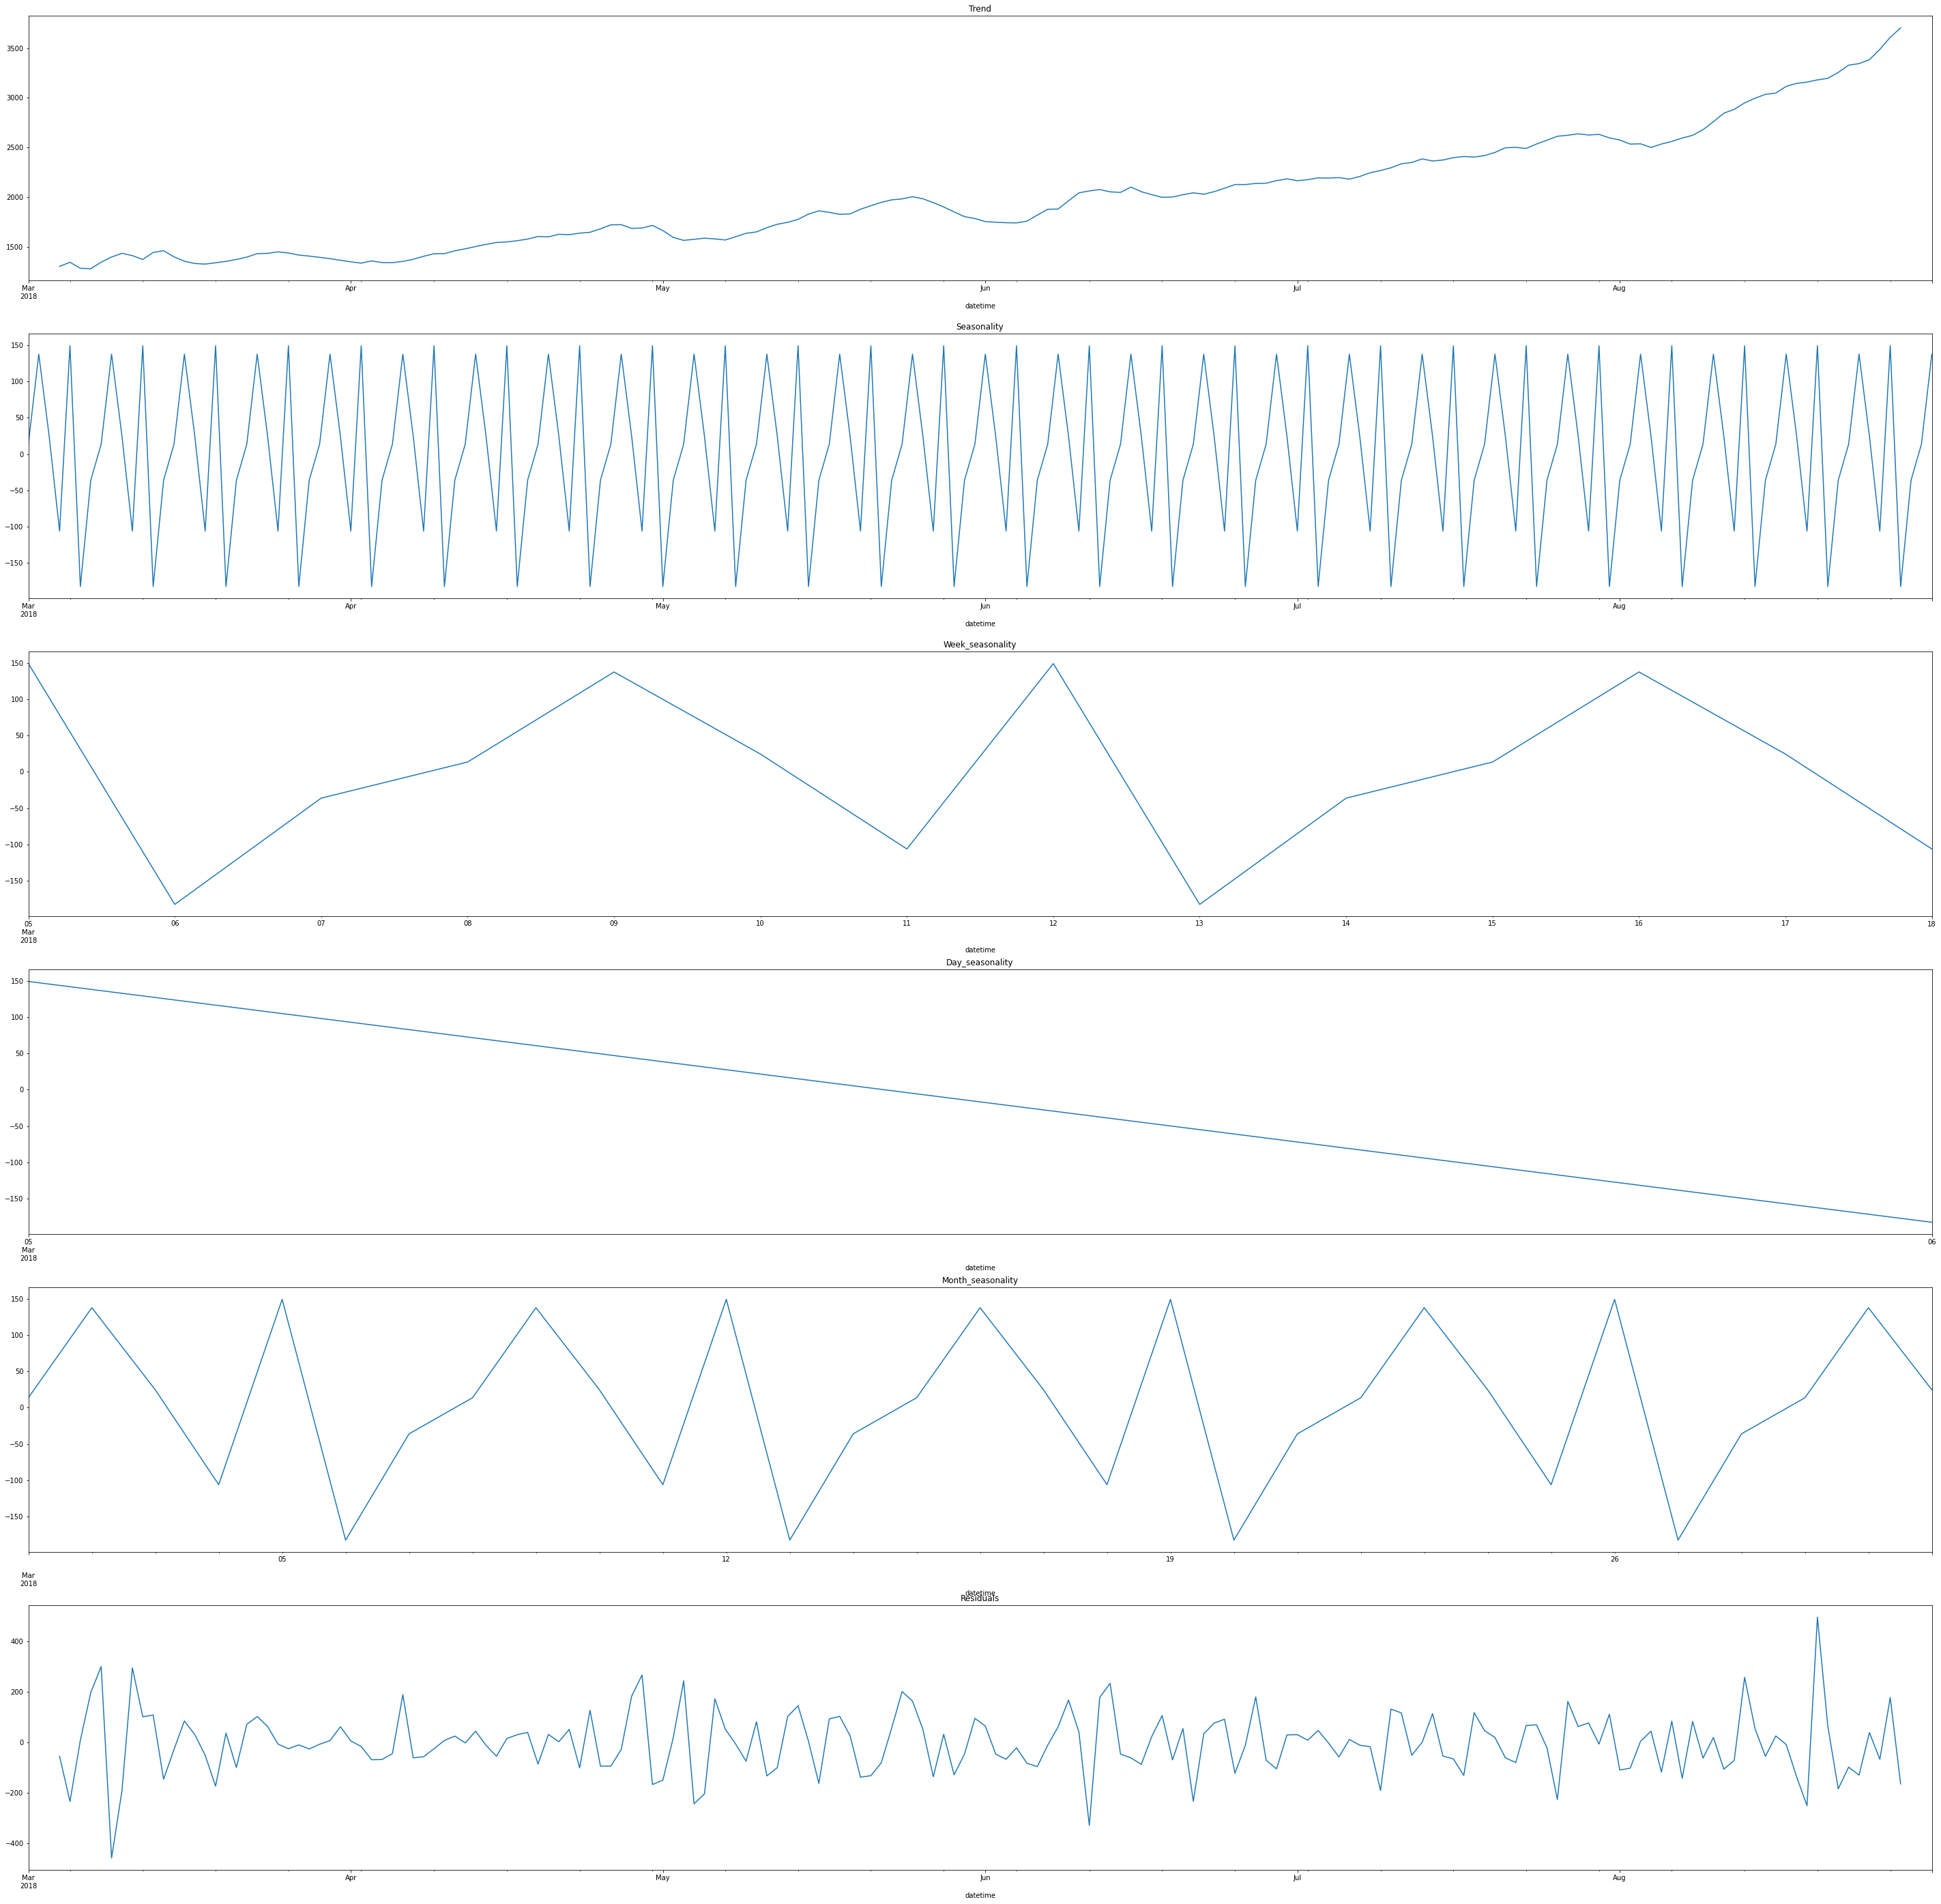

In [46]:
decomposed = seasonal_decompose(df_analysis.num_orders)
fig,ax = plt.subplots(6,1,figsize = (50,50))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.seasonal['2018-03-05':'2018-03-18'].plot(ax=ax[2],title = 'Week_seasonality')  #возьмем 2 недели с понедельника
decomposed.seasonal['2018-03-05':'2018-03-06'].plot(ax=ax[3],title = 'Day_seasonality')
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=ax[4],title = 'Month_seasonality')
decomposed.resid.plot(ax=ax[5],title = 'Residuals')

Итак, у нас в распоряжении данные за пол года : с 1 марта по 31 августа 2018.  
По таким данным невозмонжо понять что происходит каждый год (например, каждую весну или лето), но можно посмотреть, что меняется от месяца к месяцу.

* по графику тренд можно отследить равномерное увеличение количества заказов такси с небольшим проседанием в начале каждого месяца. Также можно предположить, что летний период "лучше", чем весенний.  
* по графику сезонность сложно что-то сказать, кроме того, что закономерность какая-то действительно есть. Посмотрим поближе.  
* график сезонности за 2 недели показывает нам, что во вторник и воскресенье заказов меньше всего.  
* остатки это шум - необъяснимый.

<font color="green">Обычно стоит проверять три вида сезонности (периодичности): 
внутрисуточную (по часам или утро-день-вечер-ночь), недельную (зависимость от дня недели) и месячную сезонность (месяцы или кварталы или зима-весна-лето-осень).   
Без учета такой сезонности можно взять данные за небольшой период и увидеть явный рост бизнеса. А окажется, что это сезонный рост продаж :)    
В случае заказов такси самое очевидная сезонность - внутри суток и день недели, логично предположить например, что каждую пятницу число заказов увеличивается</font>


***

Создадим функцию для создания новых фичей из даты  

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
        
    # Использование года, месяца для определения тренда не особо поможет, 
    # т.к. у нас данные за период меньше года.
    
    data['dayofweek'] = data.index.dayofweek # есть недельная сезонность
    data['hour'] = data.index.hour # есть часовая (суточная) сезонность.
    
    # lag подходит, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # rolling подходит, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 5, 24)

In [12]:
print(df)

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   
...                         ...        ...   ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136          4    19  207.0  217.0  197.0  116.0   
2018-08-31 20:00:00         154          4    20  136.0  207.0  217.0  197.0   
2018-08-31 21:00:00         159          4    21  154.0  136.0  207.0  217.0   
2018-08-31 22:00:00         223          4    22  159.0  154.0  136.0  207.0   
2018-08-31 23:00:00         205         

## Обучение

### Разделение выборки на обучающую и тестовую

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders',axis = 1)
target_test = test['num_orders']

print('Размер обучающей выборки', features_train.shape[0])
print('Размер тестовой выборки', features_test.shape[0])

Размер обучающей выборки 3950
Размер тестовой выборки 442


### Решающее дерево 

In [14]:
%%time

DTR = DecisionTreeRegressor(random_state = 12345)
parameters_grid = {'max_depth' : range(1,21)}
#DTR_model = GridSearchCV(DTR, parameters_grid, cv=5, scoring = 'neg_root_mean_squared_error') #old version
# Так нельзя. При обычной кросс-валидации перемешиваются сплиты, а у нас же временной ряд.

tscv = TimeSeriesSplit(n_splits=20)
gsearch = GridSearchCV(estimator=DTR, cv=tscv, param_grid=parameters_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)


gsearch.fit(features_train, target_train)
print("Best parameters:")
print(gsearch.best_params_)
print("Best score:")
RMSE_DTR = gsearch.best_score_*(-1)
print(gsearch.best_score_*(-1))

Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters:
{'max_depth': 7}
Best score:
27.09854518125551
CPU times: user 4.49 s, sys: 32.3 ms, total: 4.52 s
Wall time: 4.54 s


<font color="green">     
Когда у нас временной ряд, то также можно использовать кросс-валидацию, но немного другую - TimeSeriesSplit . Тогда сможем подбирать параметры с помощью GridSearchCV(). 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html . 
    
Обычная кросс-валидация  перемешивает данные, чего во временных рядах делать нельзя. Когда мы исследуем временной ряд в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.   
  ```Python
    tscv = TimeSeriesSplit(n_splits=10)   
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)   
    gsearch.fit(X, y)   
```
На русском https://scikit-learn.ru/3-1-cross-validation-evaluating-estimator-performance/    
Еще тут материалы: https://habr.com/ru/company/ods/blog/327242/ и https://russianblogs.com/article/3483456373/ </font>


In [15]:
DTR_model = DecisionTreeRegressor(max_depth=7,random_state = 12345)
DTR_model.fit(features_train, target_train)
target_predict = DTR_model.predict(features_train)
final_RMSE_DTR = mean_squared_error(target_train, target_predict) ** 0.5  
final_RMSE_DTR

22.066180557324124

In [16]:
target_predict = DTR_model.predict(features_test)
test_RMSE_DTR = mean_squared_error(target_test, target_predict) ** 0.5
test_RMSE_DTR

54.985046301034906

### Случайный лес

In [17]:
%%time

RFR = RandomForestRegressor(random_state = 12345)
parameters_grid = {"max_depth": range(1,6),
                  "n_estimators": range(10,51,20)}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=RFR, cv=tscv, param_grid=parameters_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

gsearch.fit(features_train, target_train)

print("Best parameters:")
print(gsearch.best_params_)
RMSE_RFR = gsearch.best_score_*(-1)
print("Best score:")
print(gsearch.best_score_*(-1))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters:
{'max_depth': 5, 'n_estimators': 50}
Best score:
28.614360416647223
CPU times: user 6.18 s, sys: 31.4 ms, total: 6.21 s
Wall time: 6.23 s


In [18]:
RFR_model = RandomForestRegressor(max_depth=5, n_estimators=50,random_state = 12345)
RFR_model.fit(features_train, target_train)
target_predict = RFR_model.predict(features_train)
final_RMSE_RFR = mean_squared_error(target_train, target_predict) ** 0.5  
final_RMSE_RFR

23.793497768981357

In [19]:
target_predict = RFR_model.predict(features_test)
test_RMSE_RFR = mean_squared_error(target_test, target_predict) ** 0.5
test_RMSE_DTR

54.985046301034906

<font color="green">
    Качество предсказания на train и test сильно отличается - большая разница между их RMSE. Значит, идет переобучение</font>


### Линейная регрессия

In [20]:
%%time

LR = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(LR, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error').mean() * -1)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 30.593276771467778
CPU times: user 35.6 ms, sys: 11.8 ms, total: 47.4 ms
Wall time: 25.7 ms


In [21]:
LR.fit(features_train, target_train)
target_predict = LR.predict(features_train)
final_RMSE_LR = mean_squared_error(target_train, target_predict) ** 0.5
final_RMSE_LR

30.662203092705894

In [22]:
target_predict = LR.predict(features_test)
test_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
test_RMSE_LR

50.2890192085309

### CatBoostRegressor

In [23]:
%%time

CBR = CatBoostRegressor(learning_rate=0.5,
                        iterations = 200,
                        random_state=12345, 
                        verbose=False) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR = (cross_val_score(CBR,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_root_mean_squared_error').mean() * -1) 
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 25.91223482488412
CPU times: user 1.81 s, sys: 105 ms, total: 1.92 s
Wall time: 5.36 s


In [24]:
CBR = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False) 
CBR.fit(features_train, target_train)
target_predict = CBR.predict(features_train)
final_RMSE_CBR = mean_squared_error(target_train, target_predict) ** 0.5
final_RMSE_CBR

10.564546268028122

In [25]:
target_predict = CBR.predict(features_test)
test_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5
test_RMSE_CBR

44.673716137176065

### LightGBM

In [26]:
%%time

LGBM = LGBMRegressor() 
parameters_grid = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=LGBM, cv=tscv, param_grid=parameters_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

gsearch.fit(features_train, target_train)

print("Best parameters:")
print(gsearch.best_params_)
RMSE_LGBM = gsearch.best_score_*(-1)
print("Best score:")
print(gsearch.best_score_*(-1))

# Tuning hyper-parameters for root_mean_squared_error

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters:
{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
Best score:
25.619024657353823
CPU times: user 4min 17s, sys: 1.79 s, total: 4min 19s
Wall time: 4min 21s


In [27]:
LGBM = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=31, 
                      random_state=12345)
LGBM.fit(features_train, target_train)
target_predict = LGBM.predict(features_train)
final_RMSE_LGBMR = mean_squared_error(target_train, target_predict) ** 0.5
final_RMSE_LGBMR

15.30850804890076

In [28]:
target_predict = LGBM.predict(features_test)
test_RMSE_LGBM = mean_squared_error(target_test, target_predict) ** 0.5
test_RMSE_LGBM

44.0725499416811

### Таблица результатов

In [29]:
index = ['DecisionTree',
         'RandomForest',
         'LinearRegression',
         'CatBoost',
         'LightGBM']
data = {'RMSE при поиске лучших гиперпараметров':[RMSE_DTR,
                                     RMSE_RFR,
                                     cv_RMSE_LR,
                                     cv_RMSE_CBR,
                                     RMSE_LGBM],
        'RMSE модели на обучающей выборке':[final_RMSE_DTR,
                                           final_RMSE_RFR,
                                           final_RMSE_LR,
                                           final_RMSE_CBR,
                                           final_RMSE_LGBMR],
        'RMSE модели на тестовой выборке':[test_RMSE_DTR,
                                           test_RMSE_RFR,
                                           test_RMSE_LR,
                                           test_RMSE_CBR,
                                           test_RMSE_LGBM]}
scores_data = pd.DataFrame(data=data, index=index)

In [30]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

scores_data.style.background_gradient(cmap=cm)

,RMSE при поиске лучших гиперпараметров,RMSE модели на обучающей выборке,RMSE модели на тестовой выборке
DecisionTree,27.098545,22.066181,54.985046
RandomForest,28.614360,23.793498,53.937345
LinearRegression,30.593277,30.662203,50.289019
CatBoost,25.912235,10.564546,44.673716
LightGBM,25.619025,15.308508,44.072550


## Тестирование

<font color="green">
    target_predict после обучения каждой модели
</font>

## Вывод

Ура, я наконец-то исправила все ошибки!  
Итак,  
- были загружены данные
- посмотрели на них, сделала ресемплирование по ЧАСУ, проверили пропуски и проверила на расположение в хронологическом порядке
- провела анализ сначала на ресемплированных по дню данных
- затем сделала уточняющий анализ с трендом и сезонностью
- создала новые фичи из даты
- провела обучение на 5 моделях
- провела на них же тестирование

В общем хочется сказать, что данных у нас было немного, всегда пол года, поэтому сезонность год к году, время года друг другу провести не удалось.  
Проведя анализ данных был замечен возрастающий тренд с 1 марта по 31 августа с небольшим проседанием в начале каждого месяца. Можно сказать, что летом заказов больше чем весной.  
Также была выявлена сезонность, а именно: сезонность за 2 недели показывает нам, что во вторник и воскресенье заказов меньше всего, а в пятницу больше всего, что очевидно)  суточная сезонность говорит о том, что с утра заказов гораздо больше чем вечером, количество заказов линейно убывает.По месячной сезонности трудно что-то понять.
Что касается моделей - лучше всего себя показала LightGBM. С результатом RMSE на тестовых данных - 44.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48